In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm  # Colormaps
from matplotlib.colors import LogNorm
import seaborn as sns  # Fancier plots
from utils.printProgressBar import printProgressBar
sns.set_style('darkgrid') # Set seaborn plotting style

import torch
import torch.nn as nn
import torch.optim as optim

Now type in the terminal:
    
`ffmpeg -pattern_type glob  -f image2 -r 1/0.2 -i "*.png" -vcodec mpeg4 output.mp4`


In [2]:
N = 100

def get_lemniscat(size=300, a=1, offset=0):
    t = np.linspace(np.pi/2, 4.5*np.pi, size)
    x = a*np.cos(t)/(1+np.sin(t)**2) + offset
    y = a*np.sin(t)*np.cos(t)/(1+np.sin(t)**2) + offset
    x = np.vstack((x,y)).transpose(1,0)
    y = np.roll(x, -1, axis=0)
    return x, y

def generate_data(N=100, offset = 0.7):
    theta = np.linspace(-2*np.pi, 2*np.pi, N).reshape(-1, 1)
    x = np.concatenate((0.25 * np.cos(theta), 0.25 * np.sin(theta)), axis=1) + offset
    y = np.roll(x, -1, axis=0)
    return x, y


# x,y = get_lemniscat(size=N, a=0.5, offset=1)
# x,y = generate_data(N=N)

In [33]:
def get_pic(rnn, epoch, loss, input, x):
    offset = 0.0
    np.random.seed(seed=11)
    fig = plt.figure(figsize=(8,8))
    ax0 = fig.add_subplot(121)
    ax0.scatter([x[i,0] for i in range(len(x))], [x[i, 1] for i in range(len(x))], s=1, label='Ground Truth')
    
    hidden = rnn.initHidden()
    output, hidden = rnn(input, hidden)
    output = output.squeeze().detach().numpy()
    ax0.scatter(output[:,0], output[:,1], label='prediction', s=3)

    for j in range (100):
        out = torch.tensor(np.random.uniform(low=-1 + offset, high=1 + offset, size=(1,1,input.shape[2])), dtype=torch.float)
        hidden = rnn.initHidden()
        OUT0, OUT1 = [], []
        for i in range(input.shape[0]):
            OUT0.append(out[0,0,0].item())
            OUT1.append(out[0,0,1].item())
            out, hidden = rnn(out, hidden)
        ax0.plot(OUT0, OUT1, linewidth=0.125, c='black')
    
    out = input[0,:,:].view(1,1,input.shape[2])
    hidden = rnn.initHidden()
    OUT0, OUT1 = [], []
    for i in range(100):
        OUT0.append(out[0,0,0].item())
        OUT1.append(out[0,0,1].item())
        out, hidden = rnn(out, hidden)
    ax0.plot(OUT0, OUT1, linewidth=2, c='g', label='Convergence towards attractor from x[0]')
    
    ax0.set_ylim([-2, 2])
    ax0.set_xlim([-2, 2])
    ax0.set_title('Convergence towards attractor from random points and x[0]')
    ax0.legend()
    ax1 = fig.add_subplot(122)
    ax1.plot(loss)
    ax1.set_title('Epoch: {:05d} Loss: {:.3f}'.format(epoch, loss[-1]))

    fname = 'img_dump/img_{:05d}.png'.format(epoch)
    fig.savefig(fname)
    plt.close('all')

In [34]:
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size):
        super(RNN, self).__init__()                  # extend the functionality of previously built classes.
        self.hidden_size = hidden_size
        self.cell_type = cell_type
        # YOU CAN USE EITHER LSTM, GRU OR VANILLA RNN
        if self.cell_type=='GRU':
            self.rnn_cell = nn.GRU(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=1)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='LSTM':
            self.rnn_cell = nn.LSTM(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=1)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='RNN':
            self.rnn_cell = nn.RNN(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=1)            # how many LSTM cells we want to stack (defalult=1)

        self.dense = nn.Linear(hidden_size, output_size)
        self.activate = nn.Sigmoid()
        
        self.optimizer = optim.RMSprop(self.parameters(),
                                       lr=0.001,
                                       momentum=0.00,
                                       weight_decay=0.000,
                                       centered=False)
#         self.optimizer = optim.SGD(self.parameters(), lr=0.005)
        
    def forward(self, input, hidden):
        output, hidden = self.rnn_cell(input, hidden)
        output = self.dense(output)
        output = self.activate(output)
        return output, hidden

    def initHidden(self):
        if self.cell_type=='LSTM': # we initialize a 2-tuple of hidden states (hidden state, memory)
            return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        if self.cell_type=='GRU' or self.cell_type=='RNN': # we initialize a hidden state
            return torch.zeros(1, 1, self.hidden_size)

In [40]:
input_size  = 2
hidden_size = 4
output_size = 2
cell_type = 'GRU'

EPOCHS = 5000
N = 100
offset = 0

x,y = get_lemniscat(size=N, a=0.5, offset=0.5)
# x,y = generate_data(N=N, offset=0.5)
input = torch.tensor(x, dtype=torch.float).view(x.shape[0],-1,output_size)
target = torch.tensor(y, dtype=torch.float).view(x.shape[0],-1,output_size)

criterion = nn.MSELoss()

rnn = RNN(cell_type, input_size, hidden_size, output_size)

In [41]:
# hidden = rnn.initHidden()
# output, hidden = rnn(input, hidden)
# output

In [42]:
# hidden = rnn.initHidden()
# for i in range(10):
#     output, hidden = rnn(input[i].view(1,1,2), hidden)
#     print(output)

In [43]:
LOSS = []
printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 50)
for epoch in range(EPOCHS):
    rnn.optimizer.zero_grad()
    hidden = rnn.initHidden()
    output, hidden = rnn(input, hidden)
    loss = criterion(output, target)
    loss.backward()
    LOSS.append(loss.item())
    rnn.optimizer.step()
    printProgressBar(epoch + 1, EPOCHS, prefix='Loss: {:.5f} Progress: '.format(LOSS[-1]), suffix='Complete', length=50)
    if epoch%100==0:
        get_pic(rnn, epoch, LOSS, input, x)


Loss: 0.00004 Progress:  |██████████████████████████████████████████████████| 100.0% Complete


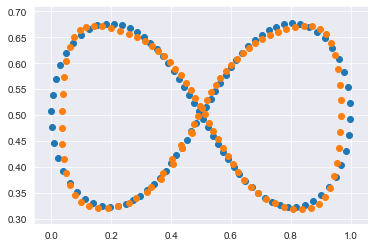

In [39]:
hidden = rnn.initHidden()
output, hidden = rnn(input, hidden)
output = output.squeeze().detach().numpy()
plt.scatter(x[:,0], x[:,1], label='GT')
plt.scatter(output[:,0], output[:,1], label='LSTM prediction')

In [66]:
import pygame
from pygame import gfxdraw
x = y = 0
running = 1
screen = pygame.display.set_mode((640, 400))
pos = []
down = 0
while running:
    event = pygame.event.poll()
    if event.type == pygame.KEYDOWN:
        if event.key==27:
            break
    if event.type == pygame.QUIT:
        running = 0
    elif event.type == pygame.MOUSEBUTTONDOWN:
        down = 1
        print('down')
    elif event.type == pygame.MOUSEBUTTONUP:
        down = 0
        print('up')
    elif event.type == pygame.MOUSEMOTION and down==1:
        pos.append((event.pos[0], event.pos[1]))
#         screen.fill((0, 0, 0))
        pygame.display.flip()
        gfxdraw.pixel(screen, event.pos[0], event.pos[1], (255,255,255))

up
down
up


Shape of inputs: (278, 2)
Shape of labels: (278, 2)


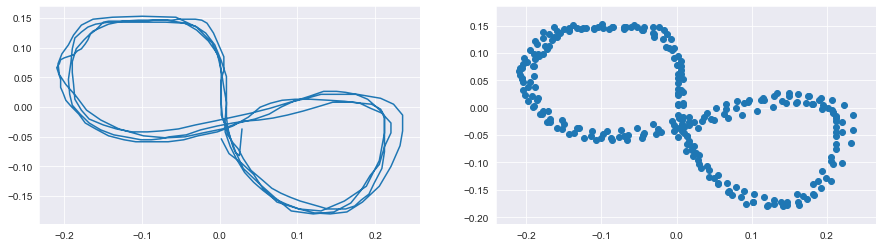

In [67]:
x = np.zeros((len(pos), 2))
for i in range(len(pos)):
    x[i,0] = pos[i][0]
    x[i,1] = pos[i][1]
x[:,0] -= np.mean(x[:,0])
x[:,1] -= np.mean(x[:,1])
    
x = x[0::5,:]/600
y = np.roll(x, -1, axis=0)

print('Shape of inputs: {}'.format(x.shape))
print('Shape of labels: {}'.format(y.shape))

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(x[:,0], y[:,1])
plt.subplot(1,2,2)
plt.scatter(x[:,0], y[:,1])

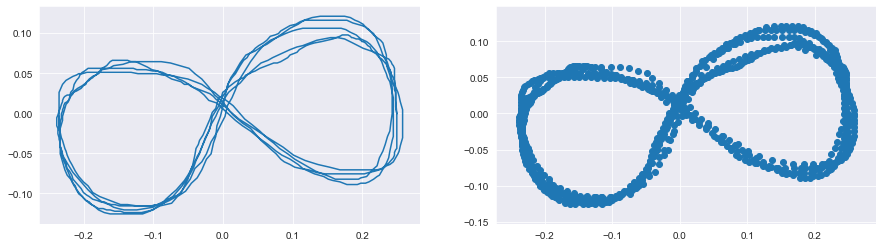

In [59]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(x[:,0], y[:,1])
plt.subplot(1,2,2)
plt.scatter(x[:,0], y[:,1])

In [277]:
x

array([[ 0.01391193, -0.02359959],
       [ 0.00724526, -0.03193292],
       [-0.00275474, -0.04026626],
       ...,
       [-0.3544214 ,  0.06973374],
       [-0.3544214 ,  0.07640041],
       [-0.3544214 ,  0.08306708]])